# Differential expression analysis


You have now successfully run the pipeline and checked the first quality control metrics of your fastq files. However, this is only primary analysis.

We would now like to understand exactly the difference between our groups of mice. 

Which pipeline would you use for this?

I would use nf-core/differentialabundance.

Please paste here the command you used

In [1]:
import pandas as pd

data = {
    'sample': ['Sham_oxy_1', 'Sham_oxy_2', 'Sham_oxy_3', 'Sham_oxy_4', 
               'Sham_Sal_1', 'Sham_Sal_2', 'Sham_Sal_3', 'Sham_Sal_4', 
               'SNI_oxy_1', 'SNI_oxy_2', 'SNI_oxy_3', 'SNI_oxy_4', 
               'SNI_Sal_1', 'SNI_Sal_2', 'SNI_Sal_3', 'SNI_Sal_4'],
    'condition': ['Sham_oxy', 'Sham_oxy', 'Sham_oxy', 'Sham_oxy', 
                  'Sham_Sal', 'Sham_Sal', 'Sham_Sal', 'Sham_Sal',
                  'SNI_oxy', 'SNI_oxy', 'SNI_oxy', 'SNI_oxy', 
                  'SNI_Sal', 'SNI_Sal', 'SNI_Sal', 'SNI_Sal'],
    'replicate': ['1', '2', '3', '4', 
                  '1', '2', '3', '4', 
                  '1', '2', '3', '4', 
                  '1', '2', '3', '4']
}

# Create DataFrame
df = pd.DataFrame(data)

# Write to CSV
df.to_csv('samplesheet.csv', index=False)

In [2]:
contrasts = {
    'id': ['SNI_oxy_vs_Sham_Sal', 'Sham_oxy_vs_Sham_Sal', 'SNI_Sal_vs_Sham_Sal', ],
    'variable': ['condition', 'condition', 'condition'],
    'reference': ['SNI_oxy', 'Sham_oxy', 'SNI_Sal'],
    'target': ['Sham_Sal', 'Sham_Sal', 'Sham_Sal']
}

# Create DataFrame
df = pd.DataFrame(contrasts)

# Write to CSV
df.to_csv('contrasts.csv', index=False)

In [2]:
!nextflow run nf-core/differentialabundance -r 1.5.0 --input samplesheet.csv --contrasts contrasts.csv --matrix salmon.merged.gene_counts.tsv --transcript_length_matrix salmon.merged.gene_lengths.tsv --genome GRCm38 --outdir output -profile docker --max_memory 8.GB -resume 


 N E X T F L O W   ~  version 24.04.4

Launching `https://github.com/nf-core/differentialabundance` [shrivelled_leibniz] DSL2 - revision: 3dd360fed0 [1.5.0]

WARN: Access to undefined parameter `monochromeLogs` -- Initialise it to a default value eg. `params.monochromeLogs = some_value`


------------------------------------------------------
                                        ,--./,-.
        ___     __   __   __   ___     /,-._.--~'
  |\ | |__  __ /  ` /  \ |__) |__         }  {
  | \| |       \__, \__/ |  \ |___     \`-._,-`-,
                                        `._,._,'
  nf-core/differentialabundance v1.5.0-g3dd360f
------------------------------------------------------
Core Nextflow options
  revision                    : 1.5.0
  runName                     : shrivelled_leibniz
  containerEngine             : docker
  container                   : [RMARKDOWNNOTEBOOK:biocontainers/r-shinyngs:1.8.8--r43hdfd78af_0]
  launchDir                   : /Users/Jessie/PycharmProje

Explain all the parameters you set and why you set them in this way.


-r is used to specify the release version of the pipeline

--input is used to provide our samplesheet as in nf-core/rnaseq, giving info about the sample IDs, fastq filepaths (not required), whether the sample is a control (Sal) or was treated (Oxy) (i.e. the condition), and the replicate number.

--contrasts specifies the contrast file which defines groups of samples to compare. We need to specify an identifier for the comparison, which column from the observations to use to define the groups (we use the condition), and then we specify which target and reference samples should be compared

--matrix gives the matrix file of the gene counts produced by Salmon in the nf-core/rnaseq pipeline

--transcript_length_matrix provides the transcript lengths file for better results

--genome specifies the mouse reference genome to be used for features

--outdir gives the output directory

--profile specifies the configuration profile



How did the pipeline perform?

It ran as expected, producing various plots and tables for our given comparisons

Would you exclude any samples? If yes, which and why?

As we identified previously with the rRNA contamination and short read length, the PCA here shows that SNI_Sal_2, SNI_Sal_4, and Sham_oxy_1 are outliers.

How many genes were differentially expressed in each contrast? Does this confirm what the paper mentions?

We need to analyze the DESeq2 results and filter the table so that nominal P < 0.05 and log2fold change ≥ |0.5|, as the authors did in the paper.

In [3]:
df1 = pd.read_csv("output/tables/differential/Sham_oxy_vs_Sham_Sal.deseq2.results.tsv", sep="\t")
filtered_Sham_oxy_vs_Sham_Sal = df1[(abs(df1['log2FoldChange']) >= 0.5) & (df1['pvalue'] < 0.05)]
print("Sham-Oxy vs Sham-Sal:", filtered_Sham_oxy_vs_Sham_Sal.shape[0], "DEGs")

df2 = pd.read_csv("output/tables/differential/SNI_oxy_vs_Sham_Sal.deseq2.results.tsv", sep="\t")
filtered_SNI_oxy_vs_Sham_Sal = df2[(abs(df2['log2FoldChange']) >= 0.5) & (df2['pvalue'] < 0.05)]
print("SNI-Oxy vs Sham-Sal:", filtered_SNI_oxy_vs_Sham_Sal.shape[0], "DEGs")

df3 = pd.read_csv("output/tables/differential/SNI_Sal_vs_Sham_Sal.deseq2.results.tsv", sep="\t")
filtered_SNI_Sal_vs_Sham_Sal = df3[(abs(df3['log2FoldChange']) >= 0.5) & (df3['pvalue'] < 0.05)]
print("SNI-Sal vs Sham-Sal:", filtered_SNI_Sal_vs_Sham_Sal.shape[0], "DEGs")

Sham-Oxy vs Sham-Sal: 25 DEGs
SNI-Oxy vs Sham-Sal: 2 DEGs
SNI-Sal vs Sham-Sal: 131 DEGs


The authors had the following results:
Sham-Oxy vs Sham-Sal: 4642 DEGs
SNI-Oxy vs Sham-Sal: 2661 DEGs
SNI-Sal vs Sham-Sal: 2934 DEGs

So they found a lot more DEGs compared to the results with our pipeline.

The paper mentions differentially expressed genes in three brain regions : the NAc, mPFC and VTA. Briefly explain what these 3 regions are.

The nucleus accumbens (NAc) plays a role in reward, motivation and reinforcement signalling, and is therefore involved in addictions. The medial prefrontal cortex (mPFC) receives information regarding stimuli and coordinates responses to stress. The ventral tegmental area (VTA) has a role in the drug and natural reward circuitry of the brain. Therefore these 3 brain regions are all involved in reward circuitry, and therefore also in addictions.

Is there anyway from the paper and the material and methods for us to know which genes are included in these regions?

Yes, Table 1 shows which differentially expressed genes are involved in different brain regions and pathways.

Once you have your list of differentially expressed genes, do you think just communicating those to the biologists would be sufficient? What does the publication state?

The list of genes itself does not have much meaning unless we know in which pathways these genes are implicated. In the paper, the authors performed pathway analysis to find out which molecular mechanisms are affected by the differentially expressed genes. Specifically, they performed Gene Ontology (GO) analysis for enriched biological processes and ingenuity pathway analysis (IPA).

Please reproduce the Venn Diagram from Figure 3, not taking into account the brain regions but just the contrasts mentioned.

/opt/homebrew/Caskroom/miniforge/base/envs/comp_workflows/lib/python3.10/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


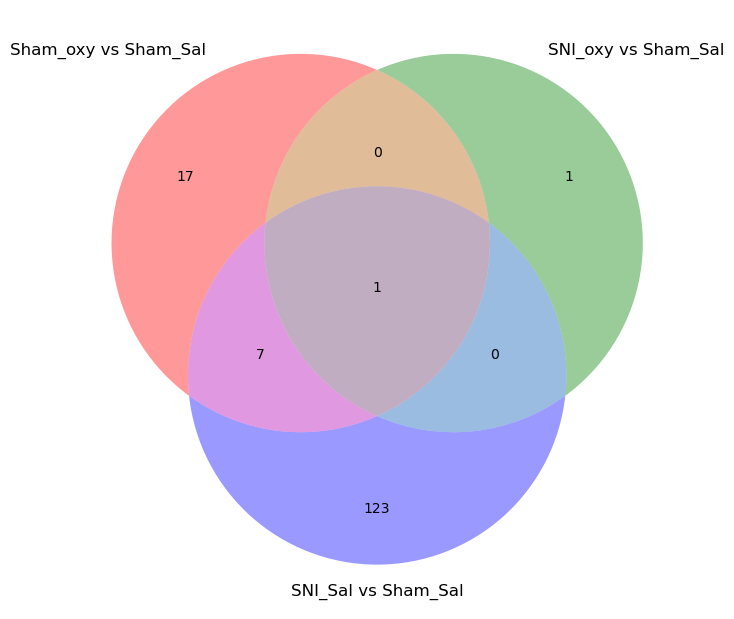

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

set1 = set(filtered_Sham_oxy_vs_Sham_Sal['gene_id'])
set2 = set(filtered_SNI_oxy_vs_Sham_Sal['gene_id'])
set3 = set(filtered_SNI_Sal_vs_Sham_Sal['gene_id'])

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn3_unweighted([set1, set2, set3], ('Sham_oxy vs Sham_Sal', 'SNI_oxy vs Sham_Sal', 'SNI_Sal vs Sham_Sal'))
plt.show()